# subsub
## 06 Batch reduce everything!!
### part I- Generate per-order HDF5 files needed for chunking, also trim off the order ends.

Michael Gully-Santiago and Natalie Gosnell at Houndstooth in Austin, TX!!
Thursday, June 8, 2017

Updated on April 6 and April 11, 2018.

Let's do it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
from astropy.io import fits
import h5py

/Users/obsidian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## H-Band

- 64 is the target
- 72 is the A0V standard

In [3]:
hdu = fits.open('../data/raw/SDCH_20150425_0064.spec_a0v.fits')
a0v_var = fits.open('../data/raw/SDCH_20150425_0072.variance.fits')
tar_var = fits.open('../data/raw/SDCH_20150425_0064.variance.fits')
hdr = hdu[0].header

In [4]:
hdu.info()

Filename: ../data/raw/SDCH_20150425_0064.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     183   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       184   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       184   (2048, 28)   float64   


What are the entries in hdu?


| index | interpretation |
|--|--|
|0 | Telluric corrected target spectrum|
|1 | Wavelength in micron|
|2 | Raw 1D spectrum of target|
|3 | Raw 1D spectrum of A0V|
|4 | Model 1D spectrum of A0V|

The variance files contain only the variance from that individual target.

In [5]:
a0v_var.info()

Filename: ../data/raw/SDCH_20150425_0072.variance.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   (2048, 28)   float32   


# Do the telluric correction

Here are the equations to compute the spectrum and its uncertainty. We need to compute the uncertainty manually because the IGRINS pipeline does not propagate the uncertainty attributable to the A0V star, and likelihood-based inference methods, like Starfish, work better when you have accurate noise models.

### propagating the uncertainty

"hats" are placed on the estimators-- models for the A0V star.   
`std` refers to standard,  
$\star$ refers to the target of interest, and  
`raw` refers to the pipeline-processed-but-not-A0V-corrected raw flux.


$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} \times \hat{f}_{std}$

$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 } \times \hat{f}_{std}$

In [6]:
f_hat_std = hdu[4].data/np.nanmean(hdu[4].data)
f_star = hdu[2].data/hdu[3].data*f_hat_std
term1 = a0v_var[0].data / hdu[3].data**2
term2 = tar_var[0].data / hdu[2].data**2
sig_star = f_star * np.sqrt( term1 + term2 ) * f_hat_std

(0, 1.55864489678146)

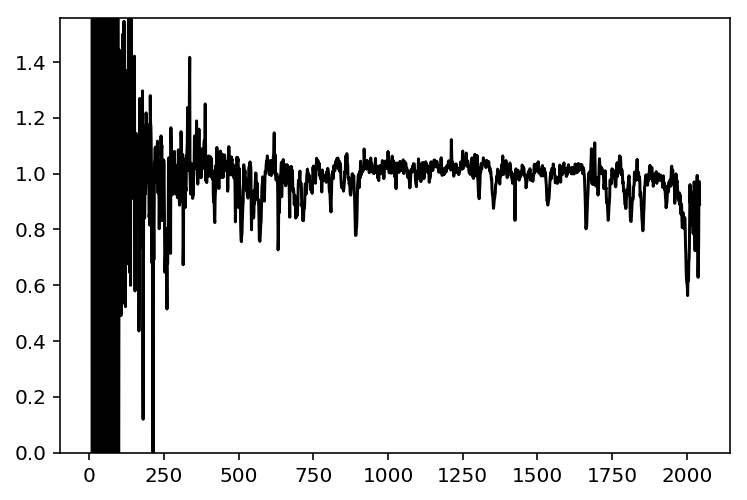

In [7]:
o=10
wls_out = hdu[1].data[o,:]*10000.0
fls_out = f_star[o,:] / np.nanmedian(f_star[o,:])

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k-')
plt.ylim(0, 1.5*np.nanpercentile(fls_out, 85))

## Plot it

We will trim between pixel 450 and 1950.

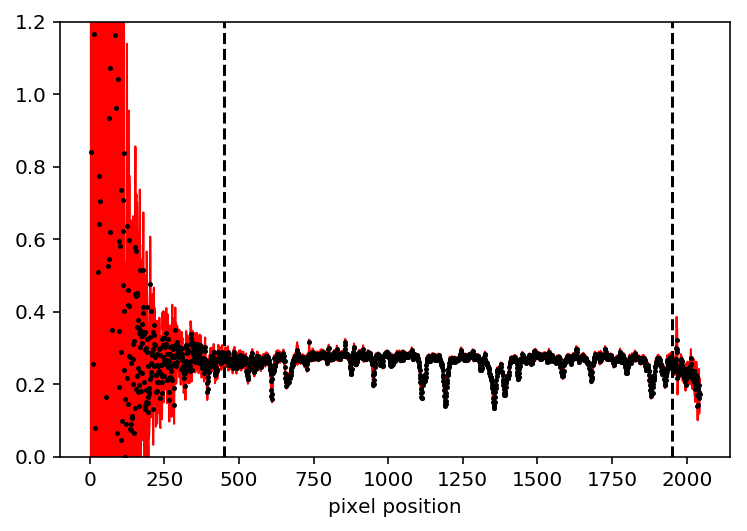

In [8]:
o=16
fls_out = f_star[o,:]
sig_out = sig_star[o,:]
wls_out = hdu[1].data[o,:]*10000.0
sig = sig_out

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k.', ms=3)
plt.xlabel('pixel position')

plt.fill_between(pix, fls_out-sig, fls_out+sig, color='r')

plt.vlines(450, 0, 2, linestyles='--')
plt.vlines(1950, 0, 2, linestyles='--')
plt.ylim(0.0, 1.2);

In [9]:
lft = 450
rgt = 1950

for o in range(28):
    m = o + 98
    out_name = '../data/reduced/subsub_IGRINS_m{:03d}.hdf5'.format(m)
    fls_out = f_star[o,lft:rgt]
    sig_out = sig_star[o,lft:rgt]
    wls_out = hdu[1].data[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    bad_ids = (sig_out < 0) | (sig_out != sig_out) | (fls_out != fls_out) 
    good_ids = ~bad_ids
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out[good_ids])
    f_new.create_dataset('wls', data=wls_out[good_ids])
    f_new.create_dataset('sigmas', data=sig_out[good_ids])
    f_new.create_dataset('masks', data=msk_out[good_ids])
    print("{:03d}: {:.0f}  -  {:.0f}   {} {}".format(m, wls_out[0],
                                                     wls_out[-1], out_name, good_ids.sum()))
    f_new.close()

098: 18154  -  18336   ../data/reduced/subsub_IGRINS_m098.hdf5 1197
099: 17975  -  18155   ../data/reduced/subsub_IGRINS_m099.hdf5 1500
100: 17800  -  17978   ../data/reduced/subsub_IGRINS_m100.hdf5 1500
101: 17628  -  17805   ../data/reduced/subsub_IGRINS_m101.hdf5 1500
102: 17460  -  17635   ../data/reduced/subsub_IGRINS_m102.hdf5 1500
103: 17295  -  17468   ../data/reduced/subsub_IGRINS_m103.hdf5 1500
104: 17133  -  17305   ../data/reduced/subsub_IGRINS_m104.hdf5 1500
105: 16975  -  17145   ../data/reduced/subsub_IGRINS_m105.hdf5 1500
106: 16819  -  16988   ../data/reduced/subsub_IGRINS_m106.hdf5 1500
107: 16667  -  16834   ../data/reduced/subsub_IGRINS_m107.hdf5 1500
108: 16517  -  16682   ../data/reduced/subsub_IGRINS_m108.hdf5 1500
109: 16370  -  16534   ../data/reduced/subsub_IGRINS_m109.hdf5 1500
110: 16226  -  16388   ../data/reduced/subsub_IGRINS_m110.hdf5 1500
111: 16084  -  16245   ../data/reduced/subsub_IGRINS_m111.hdf5 1500
112: 15945  -  16105   ../data/reduced/subsub_IG

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


## K-band

Skipping K-band because it's low signal-to-noise!

### The end!